In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras

data = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input/data', 'images*', '*', '*.png'))}
#print('data_image_paths::',data_image_paths)
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

2024-09-14 13:12:32.213910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 13:12:32.214136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 13:12:32.380952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
9066,00002371_024.png,Infiltration,24,2371,40,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_002/images/00002371_024.png
78345,00019225_001.png,No Finding,1,19225,45,F,PA,2500,2048,0.168,0.168,NaN,../input/data/images_009/images/00019225_001.png
6406,00001724_006.png,No Finding,6,1724,34,F,PA,2500,2048,0.168,0.168,NaN,../input/data/images_002/images/00001724_006.png


In [3]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
19607,00005209_000.png,,0,5209,29,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8281,00002194_003.png,,3,2194,66,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19941,00005328_000.png,Fibrosis|Pleural_Thickening,0,5328,35,M,PA,2048,2500,0.171,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


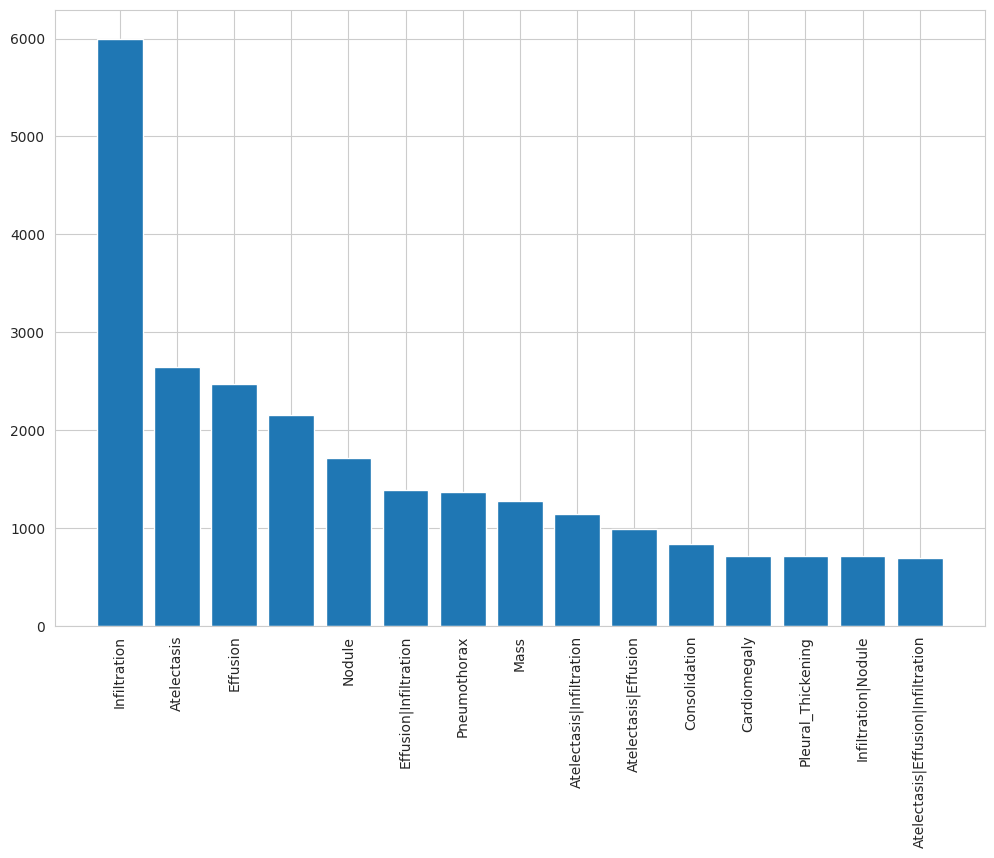

In [5]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [6]:
from sklearn.model_selection import train_test_split

# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

train_df, valid_df  = train_test_split(data, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', valid_df.shape[0])

train 30000 test 10000


In [7]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [8]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [9]:
from keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from PIL import Image
IMG_SIZE = (224, 224) # slightly smaller than vgg16 normally expects
COLOR_MODE = 'rgb'
core_idg_desne = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

# Training data generator
train_gen = core_idg_desne.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 128) # we can use much larger batches for evaluation

valid_gen = core_idg_desne.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation

train_X, train_Y = next(core_idg_desne.flow_from_dataframe(dataframe=train_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024))

test_X, test_Y = next(core_idg_desne.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024))

Found 9441 validated image filenames belonging to 13 classes.
Found 9441 validated image filenames belonging to 13 classes.
Found 28333 validated image filenames belonging to 13 classes.
Found 9441 validated image filenames belonging to 13 classes.


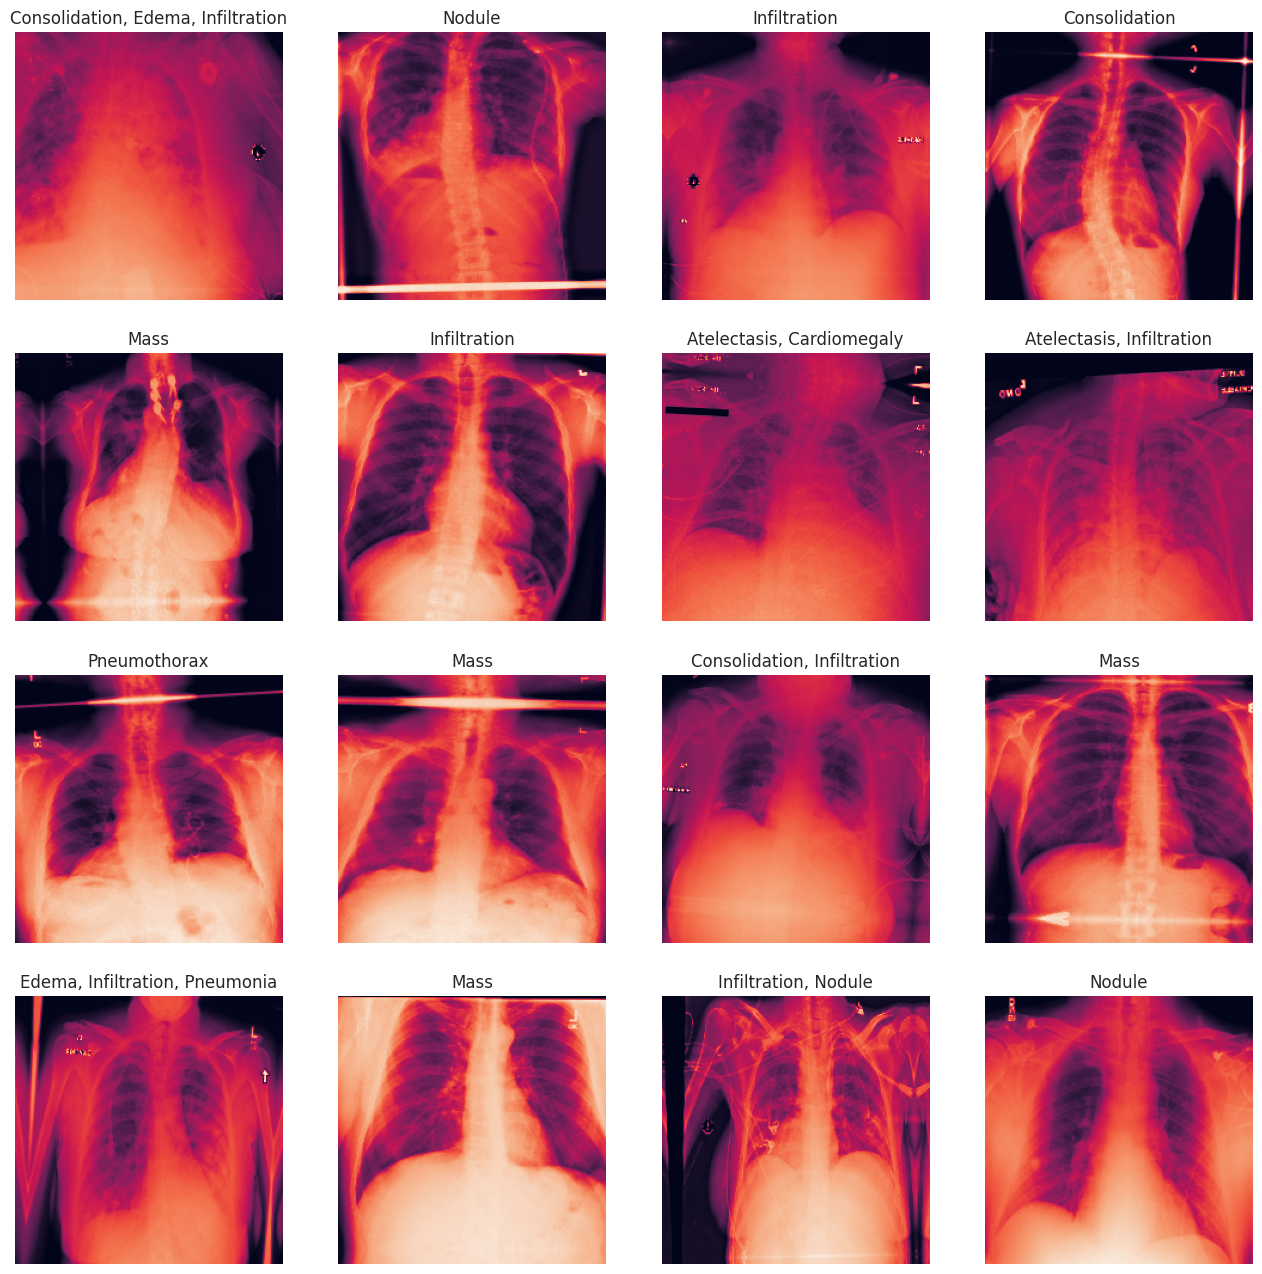

In [10]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [11]:
from tensorflow.keras.applications.densenet import DenseNet121,DenseNet169

# dense net model
img_in = Input(t_x.shape[1:])              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 

x = model.output  
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Define custom F1-score metric
def f1_score(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

# Define custom G-Mean metric
def gmean(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    recall = tp / (tp + fn + K.epsilon())
    specificity = tn / (tn + fp + K.epsilon())
    gmean = K.sqrt(recall * specificity)
    return K.mean(gmean)

# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss="binary_crossentropy", 
              metrics=[tf.keras.metrics.BinaryAccuracy(), f1_score, gmean])


In [13]:
history = model.fit(train_gen,steps_per_epoch=50,
                                  validation_data = valid_gen, 
                                  epochs = 5)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4459s 87s/step - binary_accuracy: 0.8108 - f1_score: 0.0790 - gmean: 0.1351 - loss: 0.4288 - val_binary_accuracy: 0.6813 - val_f1_score: 0.1178 - val_gmean: 0.1540 - val_loss: 1.8502
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2709s 54s/step - binary_accuracy: 0.8733 - f1_score: 0.0882 - gmean: 0.1212 - loss: 0.3208 - val_binary_accuracy: 0.8026 - val_f1_score: 0.1161 - val_gmean: 0.1546 - val_loss: 0.6595
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4381s 87s/step - binary_accuracy: 0.8755 - f1_score: 0.0905 - gmean: 0.1259 - loss: 0.3152 - val_binary_accuracy: 0.8248 - val_f1_score: 0.1004 - val_gmean: 0.1668 - val_loss: 0.4570
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2686s 53s/step - binary_accuracy: 0.8767 - f1_score: 0.1207 - gmean: 0.1636 - loss: 0.3094 - val_binary_accuracy: 0.8205 - val_f1_score: 0.1571 - val_gmean: 0.2503 - val_loss: 0.4497
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4425s 88s/step - binary_accuracy: 0.8775 - f1_score: 0.1292 - gmean: 0.1796 - loss:

**RESNET 50**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121,DenseNet169

# dense net model
img_in = Input(t_x.shape[1:])              #input of model 
model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=img_in,
    input_shape=t_x.shape[1:],
    pooling='avg'
)

x = model.output  
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

In [ ]:
history = model.fit(train_gen,steps_per_epoch=50,
                                  validation_data = valid_gen, 
                                  epochs = 5)

Epoch 1/5
 4/50 ━━━━━━━━━━━━━━━━━━━━ 47:32 62s/step - binary_accuracy: 0.8796 - f1_score: 0.1001 - gmean: 0.1403 - loss: 0.2990